#  Introduction 
- Purpose is to show competency in ETL/OSEMN(Obtain, scrub, Explore, Model, Interpret) methodologies using advanced analytic tools for interactive visualizations, computation and manipulation using various data sets. Ability to show imputation and creative approaches for structured and unstructured data with an emphasis on extracting insight from noise. Showcasing working knowledge of ML approaches

-  pandas, numpy, sql and matplotlib  = introspection, merging, creating column/rows, Concatenation, 
statistical computation, join, drop, matplotlib/sns visualize, interactive visualization. 

- regression analysis: Linear, SVM, SGD.

- The goal of this analysis is to build an accurate model estimating the rate of increased threshhold for long endurance athletes that will/could run Boston Marathon Qualifying times based on historical racing data from Half/Full Marathons and current training data. To then predict a likely % increase in the QF time per age group based on the current qualification standards set by the Boston Marathon committee 

# Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import plotly.express as px
from pandasql import sqldf
import psycopg2 as pg
import pandas.io.sql as psql
import seaborn as sns 

# Loading Data

- we will be loading multiple datasets for marathon running results along with training data from strava for the past 20 year to extract insight on the overarching trends and progression for these events. We will try to extract insight to predict the upward trend in how many people will be running boston marathon qualifying times by 2025. We will also slightly incorporate the improvement in technology and how these have had an increase in results (e.g. smart watches, shoe technology, exercise science). 

- considerations: Age groups, gender, location, elevation, training, etc..

- Data is from Kaggle, Strava, and other various results sites. Scraped from websites and obtained through kaggle. 

In [2]:
Toprun = pd.read_csv("TopRunningTimes.csv")
Marathon = pd.read_csv("MarathonData.csv")
Boston_times = pd.read_csv("marathon_results_2015.csv", "marathon_results_2016.csv", "marathon_results_2017.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



# EDA
- Lets begin by analyzing the data to see what we are looking at and begin to figure out what we can use.

In [3]:
Toprun

,Rank,Time,Name,Country,Date of Birth,Place,City,Date,Gender,Event
0,1,00:01:40.910000,David Rudisha,KEN,1988-12-17,1.0,London,2012-09-08,Men,800 m
1,2,00:01:41.010000,David Rudisha,KEN,1988-12-17,1.0,Rieti,2010-08-29,Men,800 m
2,3,00:01:41.090000,David Rudisha,KEN,1988-12-17,1.0,Berlin,2010-08-22,Men,800 m
3,4,00:01:41.110000,Wilson Kipketer,DEN,1970-12-12,1.0,Köln,1997-08-24,Men,800 m
4,5,00:01:41.240000,Wilson Kipketer,DEN,1970-12-12,1.0,Zürich,1997-08-13,Men,800 m
...,...,...,...,...,...,...,...,...,...,...
18239,1000,00:03:33.250000,Noureddine Morceli,ALG,1970-02-28,1.0,Moskva,1995-06-05,Men,1500 m
18240,1000,00:03:33.250000,Paul Korir,KEN,1977-07-15,5.0,Zürich,2003-08-15,Men,1500 m
18241,1000,00:03:33.250000,Hudson Santos de Souza,BRA,1977-02-25,5.0,Rieti,2005-08-28,Men,1500 m
18242,1000,00:03:33.250000,Issac Songok,KEN,1984-04-25,2.0,Stockholm,2006-07-25,Men,1500 m


- Lets make it so we only see marathon results and we will also drop place, rank and index time in ascending order.
- Country is irrelavant as well.

In [4]:
ToprunM = Toprun[Toprun['Event'] == "Marathon"]

ToprunM = ToprunM[ToprunM.columns.drop(list(ToprunM.filter(regex='Place')))]

ToprunM = ToprunM[ToprunM.columns.drop(list(ToprunM.filter(regex='Rank')))]

ToprunM = ToprunM[ToprunM.columns.drop(list(ToprunM.filter(regex='Country')))]

ToprunM.set_index("Time")

,Name,Date of Birth,City,Date,Gender,Event
Time,,,,,,
02:02:57,Dennis Kimetto,1984-04-22,Berlin,2014-09-28,Men,Marathon
02:03:02,Geoffrey Mutai,1981-10-07,Boston,2011-04-18,Men,Marathon
02:03:03,Kenenisa Bekele,1982-06-13,Berlin,2016-09-25,Men,Marathon
02:03:05,Eliud Kipchoge,1984-11-05,London,2016-04-24,Men,Marathon
02:03:06,Moses Mosop,1985-07-17,Boston,2011-04-18,Men,Marathon
...,...,...,...,...,...,...
02:26:23,Rael Kiyara,1984-04-04,Shanghai,2015-11-08,Women,Marathon
02:26:24,Uta Pippig,1965-09-07,New York City,1993-11-14,Women,Marathon
02:26:24,Silviya Skvortsova,1974-11-16,Berlin,2009-09-20,Women,Marathon


- For the sake of simplification lets change date of birth to age and date to year.

In [5]:
import datetime as dt
from datetime import date 

ToprunM['Age'] = pd.to_datetime(ToprunM['Date of Birth'])

ToprunM['Year'] = pd.to_datetime(ToprunM['Date']).dt.to_period('Y')

ref_date = dt.datetime.now()

ToprunM['Age'] = ToprunM['Date of Birth'].apply(lambda x: len(pd.date_range(start = x, end = ref_date, freq = 'Y')))


ToprunM.drop('Date', axis=1, inplace=True)

ToprunM.drop('Date of Birth', axis=1, inplace=True)



ToprunM

,Time,Name,City,Gender,Event,Age,Year
3001,02:02:57,Dennis Kimetto,Berlin,Men,Marathon,36,2014
3002,02:03:02,Geoffrey Mutai,Boston,Men,Marathon,39,2011
3003,02:03:03,Kenenisa Bekele,Berlin,Men,Marathon,38,2016
3004,02:03:05,Eliud Kipchoge,London,Men,Marathon,36,2016
3005,02:03:06,Moses Mosop,Boston,Men,Marathon,35,2011
...,...,...,...,...,...,...,...
16235,02:26:23,Rael Kiyara,Shanghai,Women,Marathon,36,2015
16236,02:26:24,Uta Pippig,New York City,Women,Marathon,55,1993
16237,02:26:24,Silviya Skvortsova,Berlin,Women,Marathon,46,2009
16238,02:26:24,Tatyana Filonyuk,Roma,Women,Marathon,36,2010


## Visualization
- Lets do some quick visualizations comparing the time of completion and the year it was ran seperated by men and women. 

In [6]:
ToprunM.dtypes

Time             object
Name             object
City             object
Gender           object
Event            object
Age               int64
Year      period[A-DEC]
dtype: object

- First we need to change the dypes of 'Time''City''Year' so they will be accepted by our .plt command
- We will also change the format so it is in Hours, Minutes and Seconds.
- Lastly we need to seperate Men and Women results.

In [ ]:
ToprunM['Time'] = ToprunM['Time'].astype('str')
ToprunM['City'] = ToprunM['City'].astype('str')
ToprunM['Year'] = ToprunM['Year'].astype('str')
ToprunM['Gender'] = ToprunM['Gender'].astype('str')


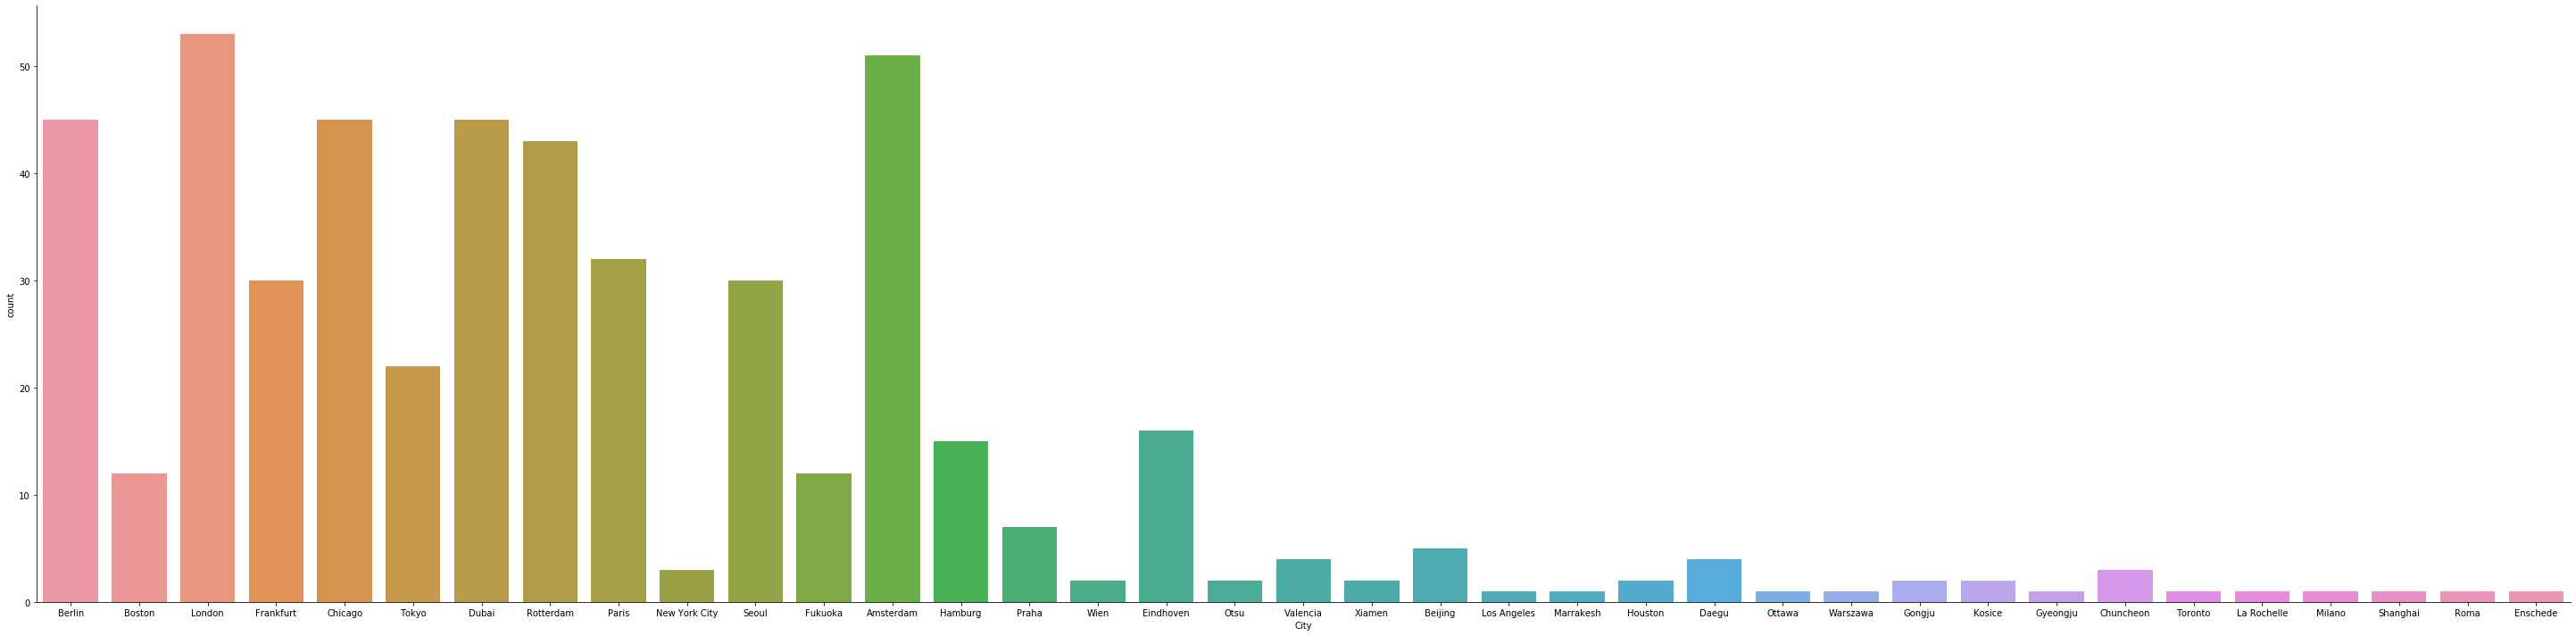

In [82]:
sns.catplot(x='City', kind='count', data= ToprunM[:500], height=10, aspect=4)

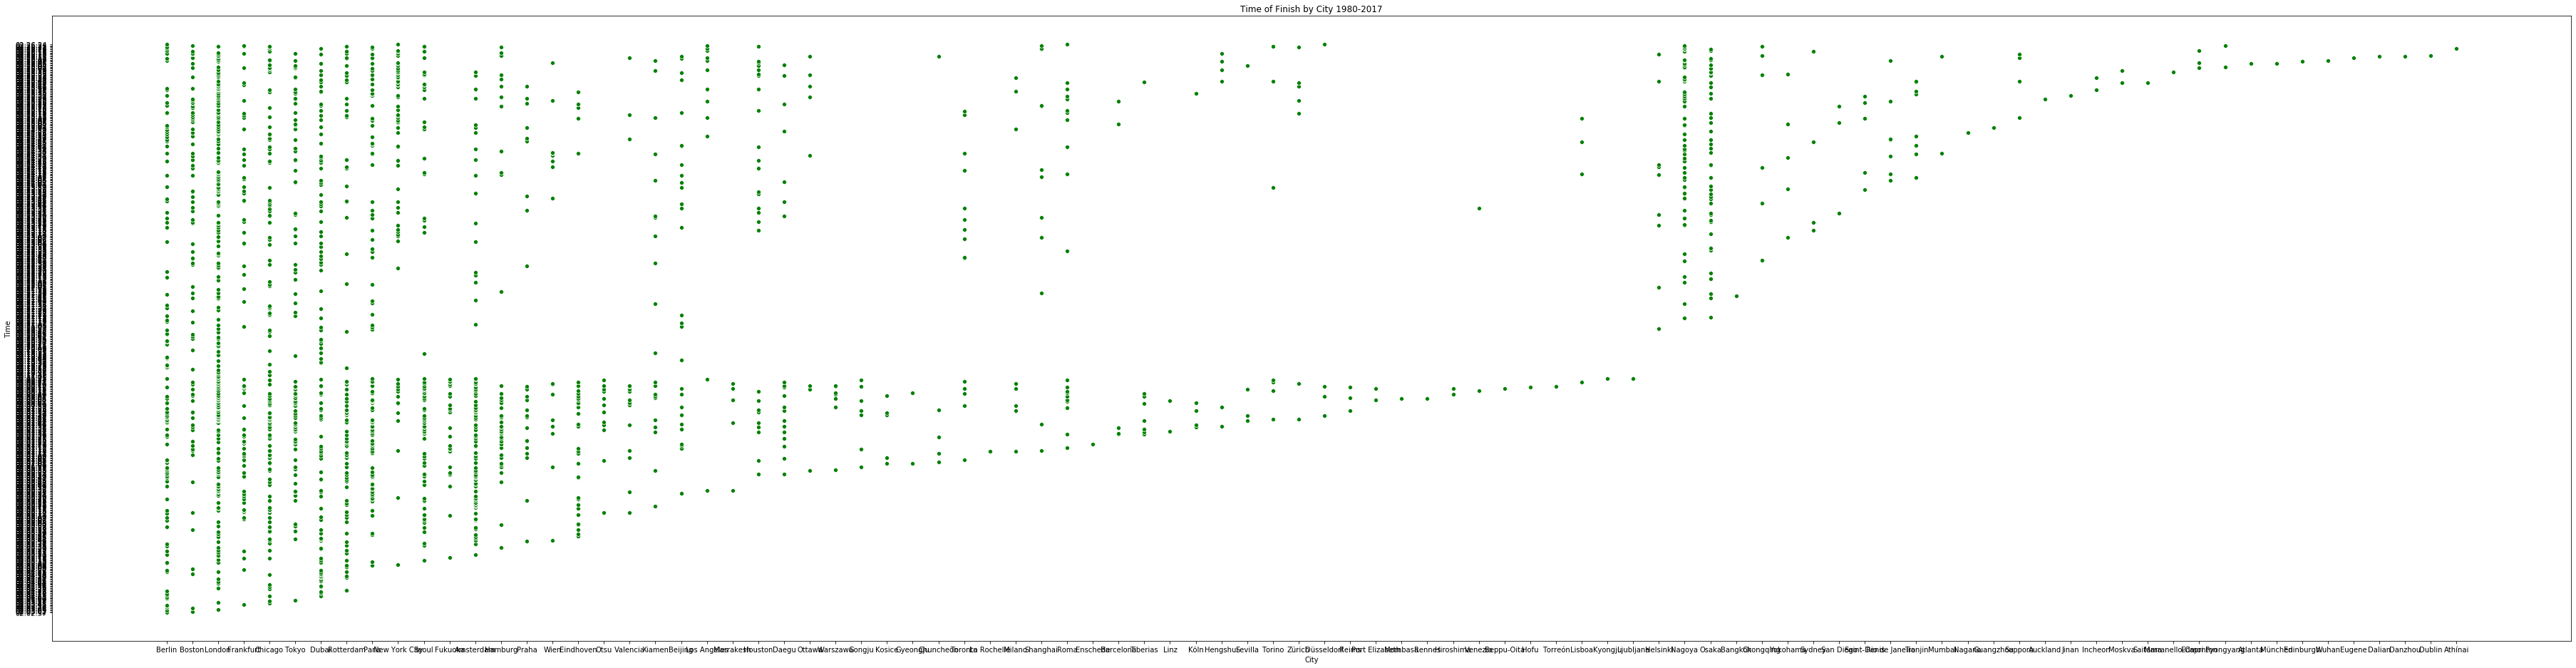

In [28]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(50,25))
                                            
ax2 = fig.add_subplot(212)
ax2 = sns.scatterplot(x="City", y="Time", data=ToprunM, color="green")
plt.title("Time of Finish by City 1980-2017")

plt.tight_layout(pad=0)
plt.show()

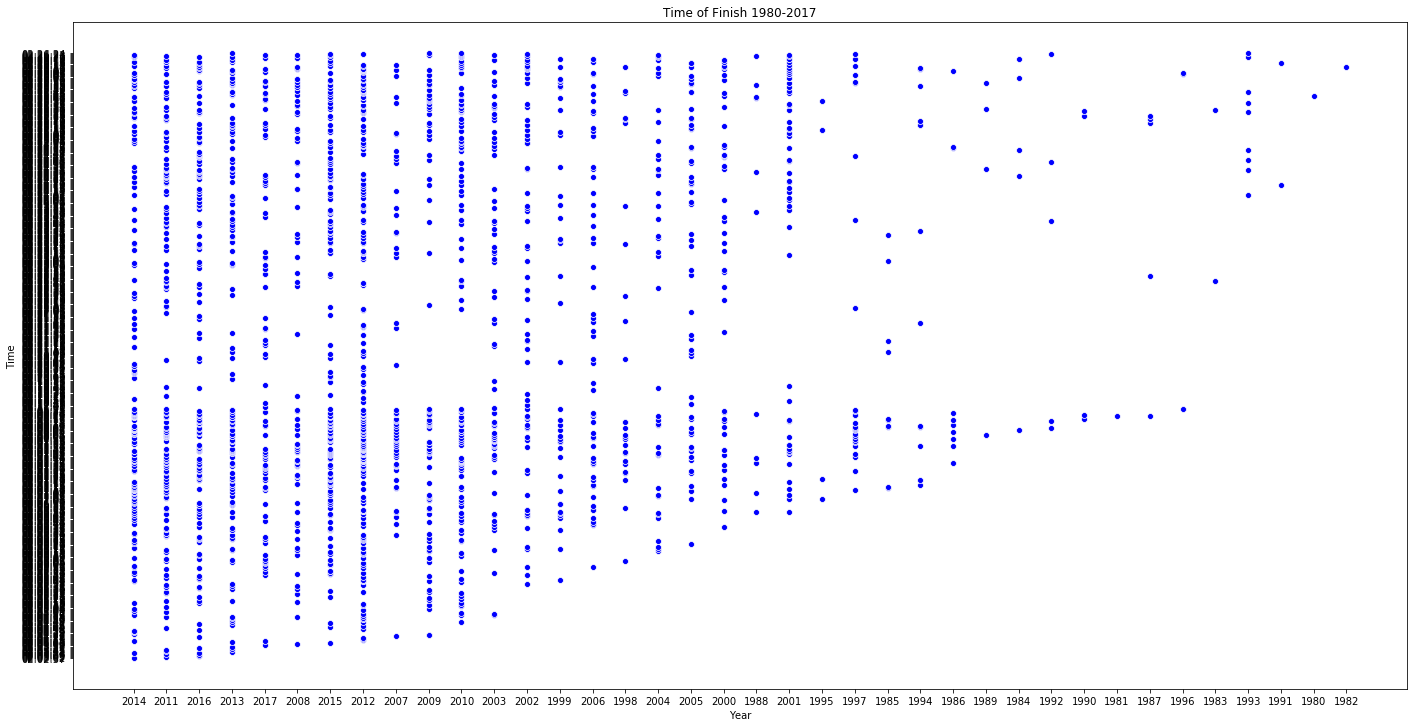

In [30]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,20))
                                            
ax2 = fig.add_subplot(212)
ax2 = sns.scatterplot(x="Year", y="Time", data=ToprunM, color="blue")
plt.title("Time of Finish 1980-2017")

plt.tight_layout(pad=2)
plt.show()

- Now lets visualize the city and time seperated by men and women 

- Finally lets visualize the age and time seperated by men 


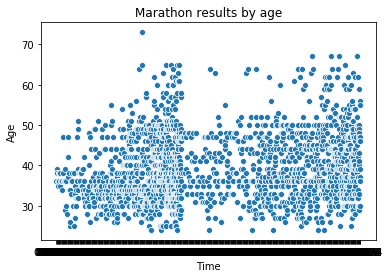

In [26]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Marathon_chart = sns.scatterplot(x="Time",
                         y="Age",
                         data=ToprunM
                         ).set_title('Marathon results by age')
plt.show()

- Lets do some basic statistcal analysis to find correlations and coefficients in the data 

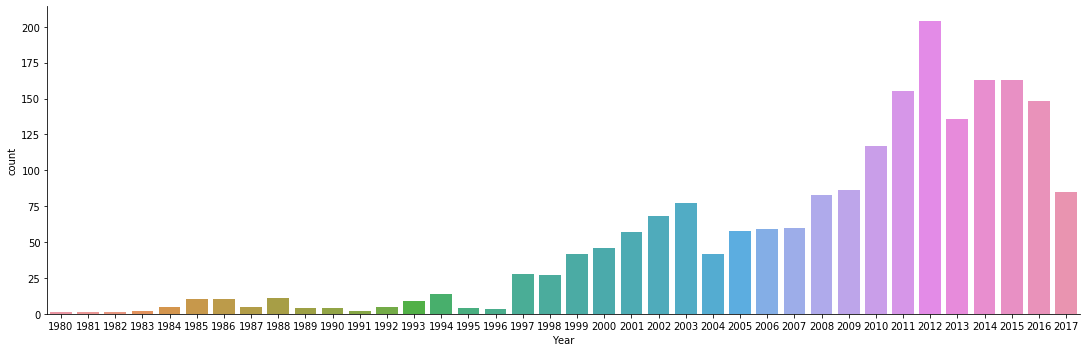

In [74]:
sns.catplot(x='Year', kind='count', data= ToprunM, height=5, aspect=3)

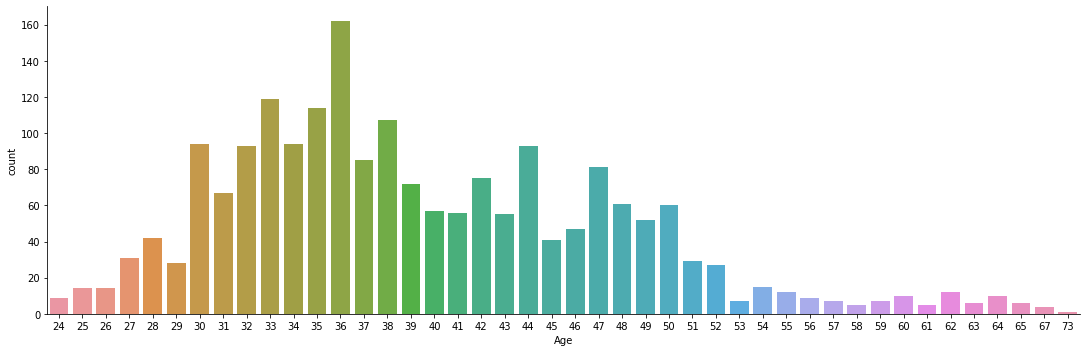

In [85]:
sns.catplot(x='Age', kind='count', data=ToprunM, height=5, aspect=3)

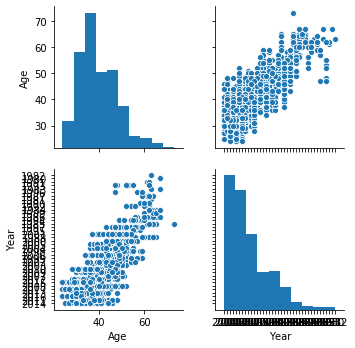

In [93]:
sns.pairplot(ToprunM)

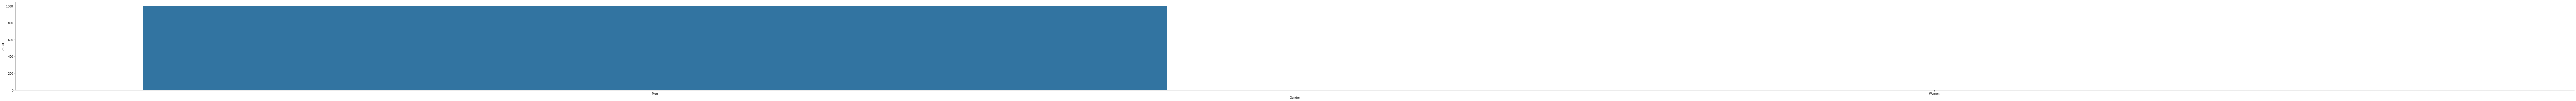

In [96]:
sns.catplot(x='Gender', kind='count', data=ToprunM[:1000], height=5, aspect=25)

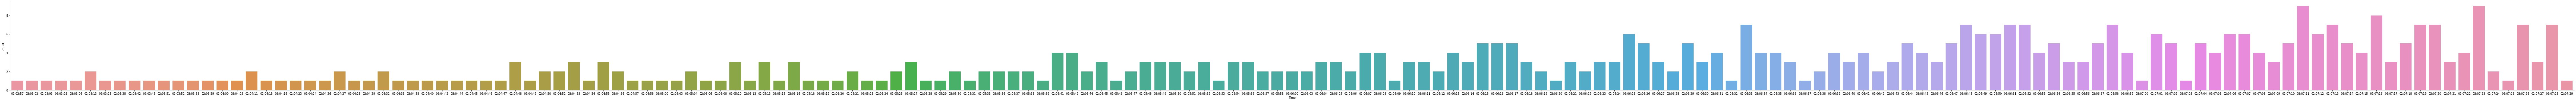

In [92]:
sns.catplot(x='Time', kind='count', data=ToprunM[:500], height=5, aspect=25)

We now know that the average age of elite marathon performaces is 36, the top 500 times have only a 5 minute difference, the top 1000 performaces have been ran by men which the majority were in the last 10 years and London and Frankfurt has the most elite performances.

- We could do a lot most customization and extraction using visualizations but we will move on to more important tasks for now, we might revisit later to enhance.

- Okay now we can look at the other datatables and see what we want to combine. (we will use sql for this part and use data that was scraped on a website.)

In [ ]:
print(sqldf('''select Name, Time, Date, City, Gender, Event from Toprun limit 10'''))

## Feature Engineering 

- We will now merge all datasets into one clear and concise dataset to prepare to use for our Algorithms
- We must then fit our training parameters to be implemented into our models. 

## Modeling

- Lets build out various models, test and compare.

- lets build a simple linear regression or decision tree/Random forest

In [187]:
ToprunM.dtypes

Time      object
Name      object
City      object
Gender    object
Event     object
Age        int64
Year       int64
dtype: object

In [116]:
from sklearn.linear_model import LinearRegression

In [ ]:
num_list = ToprunM["Time"]
float_list = [float(x) for x in num_list]
print(num_list)


In [186]:
ToprunM['Year'] = ToprunM['Year'].astype(int)

In [ ]:
ToprunM['Age'] = ToprunM['Age'].astype(int)

In [ ]:
ToprunM['Time'] = ToprunM['Time'].astype(float)

In [ ]:
#Difficulty changing the time string to a float in order to run linear regression will use age for now.
ToprunM1['time']= ToprunM['Time'].str.replace("-","").astype(float)
ToprunM1

In [188]:
year = ToprunM['Year']

In [189]:
age = ToprunM['Age']

In [190]:
x = age.values.reshape(-1,1)

In [191]:
y = year.values.reshape(-1,1)

In [192]:
reg = LinearRegression()

In [193]:
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [194]:
pred = reg.predict(x[[1]])

In [195]:
pred

array([[2009.15923906]])

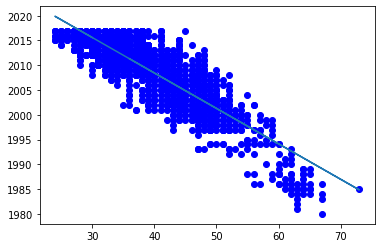

In [196]:
import numpy as np
plt.scatter(x,y, color='blue')
plt.plot(x, reg.predict(x))

- Build a SVM model

In [206]:
import sklearn
from sklearn import svm, preprocessing

ToprunM = sklearn.utils.shuffle(ToprunM) # always shuffle your data to avoid any biases that may emerge b/c of some order.

X = ToprunM["Age"].values.reshape(-1,1)
X = preprocessing.scale(X)
y = ToprunM["Year"].values.reshape(-1,1)

test_size = 200

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

clf = svm.SVR()

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

for X,y in list(zip(X_test, y_test))[:10]:
    print(f"model predicts {clf.predict([X])[0]}, real value: {y}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



0.7527914407337712
model predicts 2002.9003969163423, real value: [2009]
model predicts 2012.4484618512522, real value: [2014]
model predicts 2006.9087693417623, real value: [2011]
model predicts 2006.9087693417623, real value: [2003]
model predicts 2005.900104654559, real value: [2006]
model predicts 2007.9746139043032, real value: [2006]
model predicts 2011.5917373149532, real value: [2017]
model predicts 2012.9003477945482, real value: [2013]
model predicts 2013.1467979375163, real value: [2014]
model predicts 2011.5917373149532, real value: [2010]


- Next, building SGD model

In [209]:
import sklearn
from sklearn.linear_model import SGDRegressor

ToprunM = sklearn.utils.shuffle(ToprunM) # always shuffle your data to avoid any biases that may emerge b/c of some order.

X = ToprunM["Age"].values.reshape(-1,1)
y = ToprunM["Year"].values.reshape(-1,1)

In [210]:
test_size = 200

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

In [211]:
clf = SGDRegressor(max_iter=1000)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.7423001598039434


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [212]:
for X,y in list(zip(X_test, y_test))[:10]:
    print(clf.predict([X])[0], y)

2007.2300567476673 [2003]
2001.2791569040494 [2010]
2014.0310851403735 [2009]
2008.9303138458438 [2011]
2019.9819849839914 [2016]
2001.2791569040494 [2004]
2013.1809565912852 [2012]
2019.131856434903 [2016]
2008.9303138458438 [2015]
2002.979414002226 [2004]


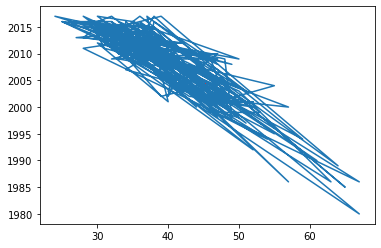

In [217]:
plt.scatter(X,y, color='red')
plt.plot(X_test, y_test)

### Boosting 
- lets use some boosting algo to enhance our results (light GBM) or (XGBOOST )

## Conclusions/Takeaways
- Visualize and compare